In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor)
from qutip.solver import heom
from scipy.integrate import quad
%matplotlib inline

In [2]:
# Set the system parameters
N = 3
g=1
J=5*g
# initial state
state_list = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
psi0 = tensor(state_list)

# Interaction coefficients
#Jx = 0.2 * np.pi * np.ones(N)
#Jy = 0.2 * np.pi * np.ones(N)
#Jz = 0.2 * np.pi * np.ones(N)

sx_list, sy_list, sz_list = [], [], []
for i in range(N):
    op_list = [qeye(2)] * N
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))

# Hamiltonian - Energy splitting terms
H = 0
for i in range(N):
    H += g* sz_list[i]

for n in range(N - 1):
    H += -J* sx_list[n] * sx_list[n + 1]
    #H += -0.5 * Jy[n] * sy_list[n] * sy_list[n + 1]
    #H += -0.5 * Jz[n] * sz_list[n] * sz_list[n + 1]

In [3]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]# Raise this question about the paper 
gamma=3.8*g
w0=1.2*E01
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2 +0j)
lam=1.15*g*np.sqrt(Omega)

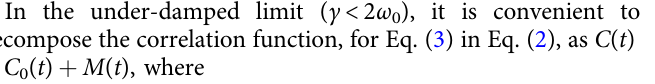

below I just check that the condition is satisfied

In [4]:
2*w0>gamma

True

In [5]:
gamma

3.8

In [6]:
Q=sz_list[-1]+ 1.1*sy_list[-1]+0.9*sz_list[-1]

Zero temperature Pseudomode fitting

In [7]:
def _matsubara_zero_integrand(t, coup_strength, bath_broad, bath_freq):
    """
    Integral for the zero temperature Matsubara exponentials.
    """
    lam = coup_strength
    gamma = bath_broad
    w0 = bath_freq

    omega = np.sqrt(w0 ** 2 - (gamma / 2) ** 2 +0j )
    a = omega + 1j * gamma/2 
    aa = np.conjugate(a)

    prefactor = -(lam ** 2 * gamma) / np.pi
    integrand = lambda x: prefactor * ((x * np.exp(-x * t)) / ((a ** 2 + x ** 2) * (aa ** 2 + x ** 2)))
    return quad(integrand, 0, np.inf,limit=5000,complex_func=True)[0]

In [8]:
times = np.linspace(0, 500, 5000)
times2 = np.linspace(0, 25, 5000)

In [9]:
C=np.array([_matsubara_zero_integrand(i,lam,gamma,w0) for i in times2])

In [10]:
cfiitter=heom.CorrelationFitter(Q,0,times2,C)
fbath,finfo=cfiitter.get_fit(Ni=1,Nr=2)
print(finfo['summary']) #notice one mode is also a pretty good approximation, maybe for this tiny examples r^{2}, might be better than RMSE

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-1.84e-02 |-3.11e+00 |3.87e-07                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
 2         |-5.11e-02 |-1.50e+01 |3.09e-10                              |                                                                        
                                                                        |A  normalized RM

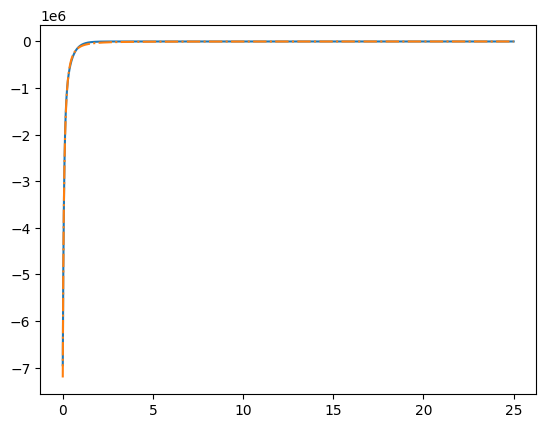

In [11]:
dd=1e8
plt.plot(times2,dd*np.real(fbath.correlation_function_approx(times2)))
plt.plot(times2,dd*np.real(C),'-.')

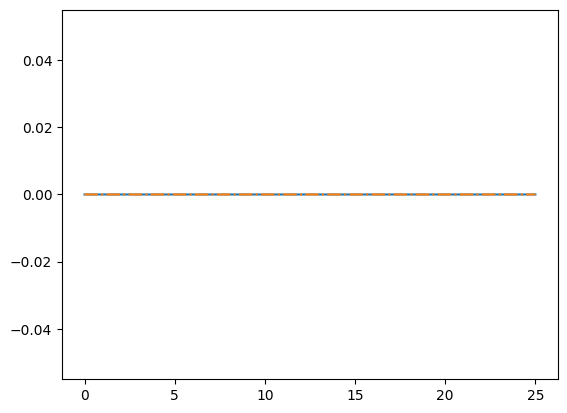

In [12]:
plt.plot(times2,np.imag(fbath.correlation_function(times2)))
plt.plot(times2,np.imag(C),'-.')

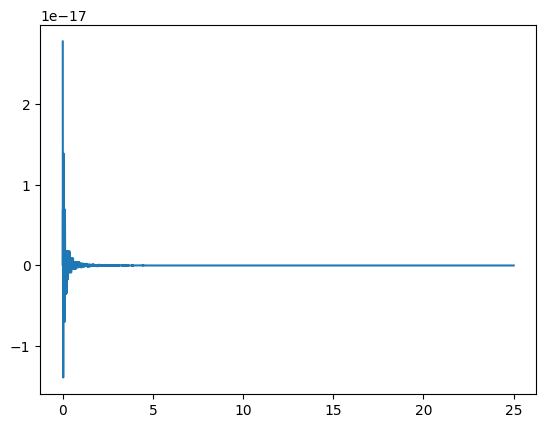

In [13]:
plt.plot(times2,np.real(C)-np.real(fbath.correlation_function(times2))) #negligeable error
plt.show()

Reproducing the full correlation function

In [14]:
def C0(t,coupling,gamma,w0,beta=np.inf):
    Gamma= gamma/2
    Omega= np.sqrt(w0**2 -Gamma**2 +0j)
    if beta!=np.inf:
        tempc0r= (1/np.tanh(beta*(Omega+ Gamma*1j)/2))*np.exp(1j*Omega*t)
    else:
        tempc0r= np.exp(1j*Omega*t)# Tookl the limit analytically because there seems to be some issues with numpy
    c0r=tempc0r+np.conjugate(tempc0r)
    c0i= -2j*np.sin(Omega*t)
    return (coupling**2 )/(2*Omega)*np.exp(-Gamma*t)*np.exp(-1j*Omega*t)

In [15]:
bath=heom.UnderDampedBath(sz_list[-1],lam+0j,gamma+0j,w0,1e-18,5) # functions don't take zero because 1/T should be fixed

In [16]:
full=bath.correlation_function(times2)

/home/mcditoos/github/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:425: RuntimeWarning: overflow encountered in exp
  return (1 / (np.exp(w / self.T) - 1))


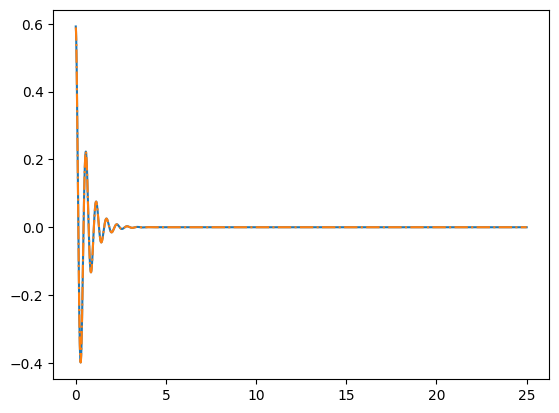

In [17]:
plt.plot(times2,np.real(C0(times2,lam,gamma,w0))+np.real(fbath.correlation_function_approx(times2)))
plt.plot(times2,np.real(full),"-.")
plt.show()

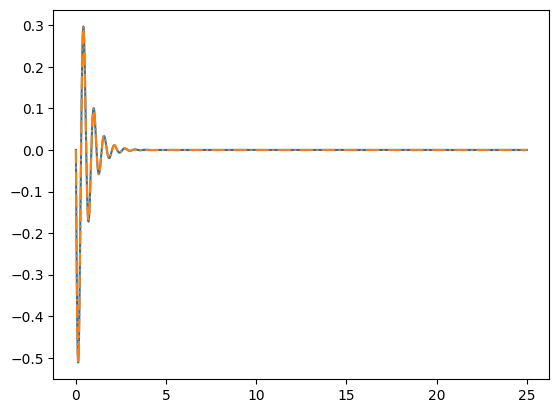

In [18]:
plt.plot(times2,
         np.imag(C0(times2,lam,gamma,w0))+np.imag(fbath.correlation_function_approx(times2)))
#plt.plot(times,-np.imag(full)-(np.imag(C0(times,lam,gamma,w0))+np.imag(fbath.correlation_function(times))),"-.")
plt.plot(times2,np.imag(full),"-.")
plt.show()

Pseudomode equation

In [19]:
cutoff=3
def tensor_id(op,pos,cutoff=cutoff):
    if pos==0:
        return tensor([op,qeye(cutoff),qeye(cutoff),qeye(cutoff)])
    if pos==1:
        return tensor([qeye(H.shape[0]),op,qeye(cutoff),qeye(cutoff)])
    if pos==2:
        return tensor([qeye(H.shape[0]),qeye(cutoff),op,qeye(cutoff)])
    else:
        return tensor([qeye(H.shape[0]),qeye(cutoff),qeye(cutoff),op])

Gamma= gamma/2
Omega= np.sqrt(w0**2 -Gamma**2)
Hsys=tensor_id(H,0)
Qeff=tensor_id(Q,0)
a=tensor_id(destroy(cutoff),1)
a.dims=Qeff.dims
b=tensor_id(destroy(cutoff),2)
b.dims=Qeff.dims
c=tensor_id(destroy(cutoff),3)
c.dims=Qeff.dims
Hpm= Omega*a.dag()*a+finfo['params_real'][2][0]*b.dag()*b+finfo['params_real'][2][1]*c.dag()*c
Hsys_pm=np.sqrt(((lam**2)/(2*Omega)))*Qeff*(a+a.dag())+1j*np.sqrt(-finfo['params_real'][0][0])*Qeff*(b+b.dag())+1j*np.sqrt(-finfo['params_real'][0][1]+0j)*Qeff*(c+c.dag())
Heff=Hsys+Hsys_pm+Hpm

In [20]:
c_ops = [np.sqrt(gamma)*a, np.sqrt(-2*finfo['params_real'][1][0]+0j)*b, np.sqrt(-2*finfo['params_real'][1][1]+0j)*c]
e_ops = [Hsys]

In [21]:
times = np.linspace(0, 50, 100)
psi02 = tensor(psi0, basis(cutoff,0), basis(cutoff,0), basis(cutoff,0))
psi02 = psi02.to("CSR")

In [22]:
pseudomodes=mesolve(Heff, psi02, times, c_ops, e_ops,options={"normalize_output":False})

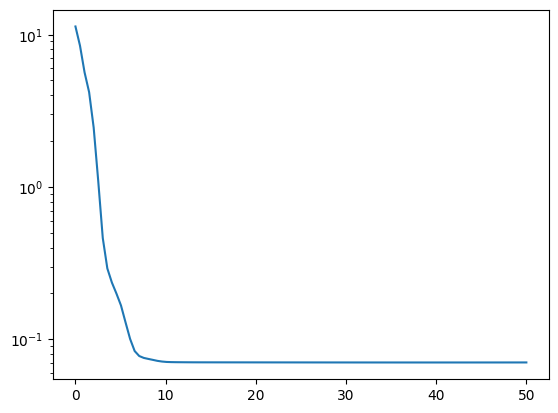

In [23]:
plt.plot(times,(pseudomodes.expect[0]-np.min(H.eigenenergies()))/g)
plt.yscale("log")

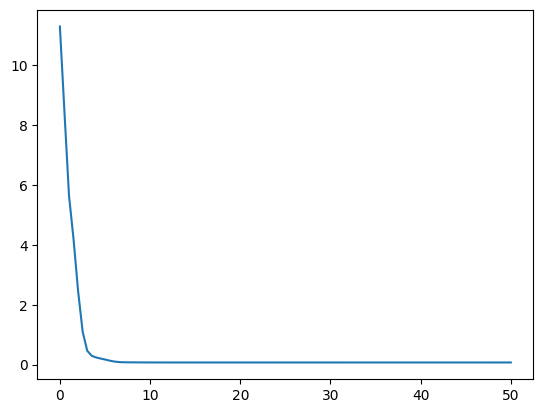

In [24]:
plt.plot(times,pseudomodes.expect[0]-np.min(H.eigenenergies()))

In [25]:
-(pseudomodes.expect[0][-1]-np.min(H.eigenenergies()))/np.min(H.eigenenergies()) *100

0.685202318384877

Check if steady state is ok using heom

In [26]:
bath=heom.UnderDampedBath(Q,lam,gamma,w0,1e-30,5) # functions don't take zero because 1/T should be fixed
times2=np.linspace(0,10,1000)
cfiitter2=heom.CorrelationFitter(Q,0,times2,bath.correlation_function)
fit2=cfiitter2.get_fit(Ni=1,Nr=4)
print(fit2[1]['summary']) #notice one mode is also a pretty good approximation
aaa=bath.correlation_function(times2)

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 4 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         | 6.63e+00 |-1.90e+00 |1.08e+01                              | 1         |-6.61e-01 |-1.90e+00 |1.10e+01                              
 2         | 1.17e+01 |-5.88e+00 |3.36e-01                              |                                                                        
 3         |-1.18e+01 |-5.91e+00 |6.01e-04                              |A  normalized RM

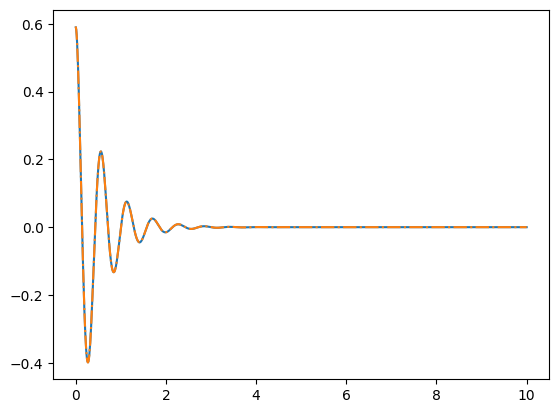

In [27]:
plt.plot(times2,np.real(aaa))
plt.plot(times2,np.real(fit2[0].correlation_function_approx(times2)),"-.")
plt.show()

In [29]:
solver = heom.HEOMSolver(H,
                    [fit2[0]], max_depth=4,options={"atol":1e-14})
result = solver.run(psi0*psi0.dag(), times)

10.1%. Run time:  19.44s. Est. time left: 00:00:02:52
20.2%. Run time:  29.48s. Est. time left: 00:00:01:56
30.3%. Run time:  40.04s. Est. time left: 00:00:01:32
40.4%. Run time:  49.77s. Est. time left: 00:00:01:13
50.5%. Run time:  58.88s. Est. time left: 00:00:00:57
60.6%. Run time:  67.69s. Est. time left: 00:00:00:44
70.7%. Run time:  76.52s. Est. time left: 00:00:00:31
80.8%. Run time:  85.31s. Est. time left: 00:00:00:20
90.9%. Run time:  94.18s. Est. time left: 00:00:00:09
100.0%. Run time: 102.14s. Est. time left: 00:00:00:00
Total run time: 102.14s


In [30]:
sdd=[(i*H).tr() for i in result.states]

In [31]:
#plt.plot(times, pseudomode.expect[0]-sdd,"-.", color="r")
#plt.show()# Add master equations to the miz and show this ones in your thesis

/home/mcditoos/miniconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/mcditoos/miniconda3/envs/qutip-dev/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


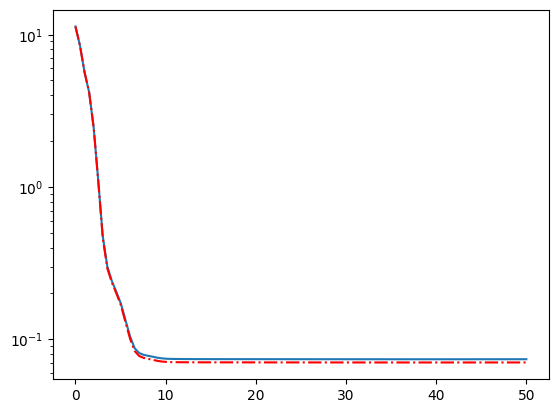

In [32]:
plt.plot(times,sdd-np.min(H.eigenenergies()))
plt.plot(times, pseudomodes.expect[0]-np.min(H.eigenenergies()),"-.", color="r")
plt.yscale("log")

In [33]:
from qutip.solver.heom import BathExponent

class pseudomode:
    def __init__(self,Hsys,Q,bath):
        """
        TODO I usually have problems with the bath exponents class so MAybe I'll just fit inside here and that's it
        """
        self.Hsys=Hsys
        self.Q=Q
        self.bath=bath
        self.coefficients()
    def coefficients(self):
        cks=np.zeros(len(self.bath.exponents),dtype=np.complex128)
        vks=np.zeros(len(self.bath.exponents),dtype=np.complex128)
        seen=set()
        i=0
        for exp in self.bath.exponents:
            if exp.vk not in seen:
                if exp.type ==BathExponent.types["R"]:
                    cks[i]=2*exp.ck 
                else:
                    cks[i]=-2j*exp.ck
                vks[i]=-exp.vk

                seen.add(exp.vk.conjugate())
                i=i+1
            
        self.cks=cks[cks!=0]
        self.vks=vks[vks!=0]
    def tensor_id(self,pos,cutoff=2,op=None):
        temp=[qeye(cutoff)]*(len(self.cks)+1)
        if pos!=0:
            temp[0]=qeye(self.Hsys.shape[0])
            temp[pos]=destroy(cutoff)
        else:
            temp[0]=op
        return tensor(temp)
    def hamiltonian(self,cutoff=2):
        Hsys=self.tensor_id(0,cutoff,self.Hsys)
        Q=self.tensor_id(0,cutoff,self.Q)
        destroys=[self.tensor_id(i+1,cutoff) for i in range(len(self.cks))]
        for i in destroys:
            i.dims=Hsys.dims
        Hpm=sum([np.imag(i)*destroys[k].dag()*destroys[k] for k,i in enumerate(self.vks) ])
        Hsys_pm=sum([np.sqrt(i+0j)*(destroys[k].dag()+destroys[k])*Q for k,i in enumerate(self.cks) ])
        Heff=Hsys_pm+Hpm+Hsys
        return Heff,destroys
    def power_spectrum(self,w):
        S=0
        for i in range(len(self.cks)):
            S += 2 * np.real(self.cks[i] / (self.vks[i] - 1j*w))
        return S
    def correlation_function(self,t):
        return self.bath.correlation_function(t)
    def prepare(self,cutoff,initial):
        init=[initial]+[basis(cutoff,0)]*(len(self.cks))
        psi02 = tensor(init)
        psi02=psi02*psi02.dag()
        return psi02.to("CSR")
    
    def evolution(self,initial,cutoff,t,e_ops=[],options={}):
        Heff,d=self.hamiltonian(cutoff)
        initial=self.prepare(cutoff,initial)
        e_ops=[self.tensor_id(0,cutoff,i) for i in e_ops]
        c_ops =[np.sqrt(-2*np.real(i) +0j)*d[k] for k,i in enumerate(self.vks) ]
        return mesolve(Heff, initial, t, c_ops, e_ops,options=options)

In [34]:
example=pseudomode(Hsys=H, Q=Q,bath=fbath)

In [35]:
example.cks=np.insert(example.cks,0,(lam**2)/(2*Omega))
example.vks=np.insert(example.vks,0,(-Gamma+1j*Omega))

In [36]:
example.vks

array([ -1.9       +1.09835418e+01j,  -3.10907728+3.86736407e-07j,
       -15.04757245+3.08532235e-10j])

In [37]:
ans=example.evolution(psi0,3,times,e_ops=[H],options={"normalize_output":False})

In [88]:
class zero_temp_bath(heom.CorrelationFitter):
    def __init__(self,Q,time,lam,gamma,w0):
        C=np.array([self._matsubara_zero_integrand(i,lam,gamma,w0) for i in time])
        super().__init__(Q,0,time,C)
        self.fbath,self.finfo =self.get_fit(Ni=1,Nr=1)
        ck=(lam**2)/(2*Omega)
        vk=(-Gamma+1j*Omega)
        C0_contrib=[BathExponent(type="R",dim=None,Q=Q,ck=ck/2,vk=-vk)]
        self.fbath.exponents.extend(C0_contrib)
        self.exponents=self.fbath.exponents
    def _matsubara_zero_integrand(self,t, coup_strength, bath_broad, bath_freq):
        """
        Integral for the zero temperature Matsubara exponentials.
        """
        lam = coup_strength
        gamma = bath_broad
        w0 = bath_freq

        omega = np.sqrt(w0 ** 2 - (gamma / 2) ** 2 +0j )
        a = omega + 1j * gamma/2 
        aa = np.conjugate(a)

        prefactor = -(lam ** 2 * gamma) / np.pi
        integrand = lambda x: prefactor * ((x * np.exp(-x * t)) / ((a ** 2 + x ** 2) * (aa ** 2 + x ** 2)))
        return quad(integrand, 0, np.inf,limit=5000,complex_func=True)[0]

times2 = np.linspace(0, 20, 50000)
batho=zero_temp_bath(Q,times2,lam,gamma,w0)
print(batho.finfo["summary"])

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 1 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-6.06e-02 |-7.66e+00 |1.69e-17                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
                                                                        |                                                                        
A  normalized RMSE of  2.96e-05 was obtained for the The Real Part Of   |A  normalized RM

In [59]:
print(finfo['summary']) #notice one mode is also a pretty good approximation, maybe for this tiny examples r^{2}, might be better than RMSE

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         |-1.84e-02 |-3.11e+00 |3.87e-07                              | 1         | 0.00e+00 | 0.00e+00 |0.00e+00                              
 2         |-5.11e-02 |-1.50e+01 |3.09e-10                              |                                                                        
                                                                        |A  normalized RM

In [89]:
example2=pseudomode(Hsys=H, Q=Q,bath=batho)

In [101]:
ans2=example2.evolution(psi0,8,times,e_ops=[H],options={"normalize_output":False})

In [108]:
example.vks

array([ -1.9       +1.09835418e+01j,  -3.10907728+3.86736407e-07j,
       -15.04757245+3.08532235e-10j])

In [109]:
example2.vks

array([-7.65882664+1.69101403e-17j, -1.9       +1.09835418e+01j])

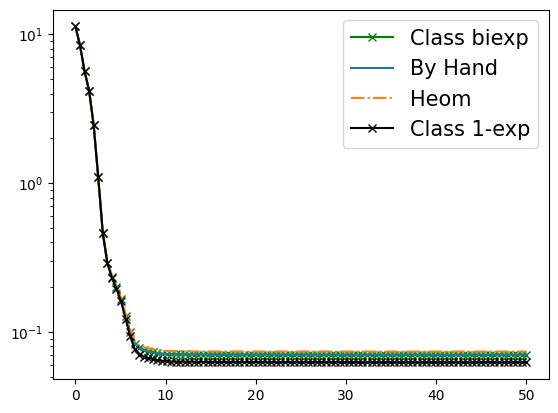

In [110]:
plt.plot(times,ans.expect[0]-np.min(H.eigenenergies()),color='g',label="Class biexp",marker="x")
plt.plot(times,pseudomodes.expect[0]-np.min(H.eigenenergies()),label="By Hand")
plt.plot(times,sdd-np.min(H.eigenenergies()),'-.',label="Heom")
plt.plot(times,ans2.expect[0]-np.min(H.eigenenergies()),color='k',label="Class 1-exp",marker="x")
plt.legend(fontsize=15)
plt.yscale("log")

In [111]:
timesf=np.linspace(0,6,1000)

In [112]:
C=bath.correlation_function(timesf)

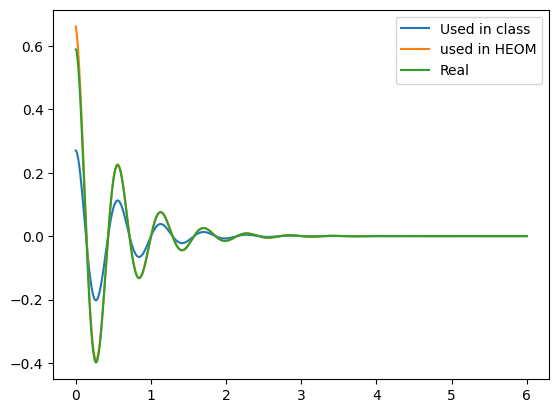

In [ ]:
plt.plot(timesf,batho.fbath.correlation_function_approx(timesf),label="Used in class")
plt.plot(timesf,bath.correlation_function_approx(timesf),label="used in HEOM")
plt.plot(timesf,C,label="Real")
plt.legend()